# 1. Introduction

Nama: Ignatius Kurniawan Eko Wibowo
<br>
Batch: RMT-032
<br>
Objective: Model ini dibuat untuk membantu para petani untuk mengenali penyakit pada tanaman apel sedini mungkin, untuk mengurangi terjadinya gagal panen. Terdapat `4 classes` di dataset yang digunakan, yaitu: **Apple Scab, Black Rot, Apple Rust** dan **Healthy Apple**. Adapun metode yang akan digunakan untuk melakukan klasifikasi adalah **Convolutional Neural Network**

# 2. Import Libraries

In [19]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import shutil
from pathlib import Path
from random import sample
from PIL import Image

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.utils import plot_model


from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 3. Data Loading

## 3.1. Loading Image Data in Tensorflow

In [21]:
# Takes the path to a directory & generates batches of augmented data from a directory

IMG_SIZE = 150
path = 'Apple/Train/'

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
data = datagen.flow_from_directory(path, (IMG_SIZE, IMG_SIZE), batch_size=32, class_mode='sparse', shuffle=True)

Found 1743 images belonging to 4 classes.


# 4. EDA

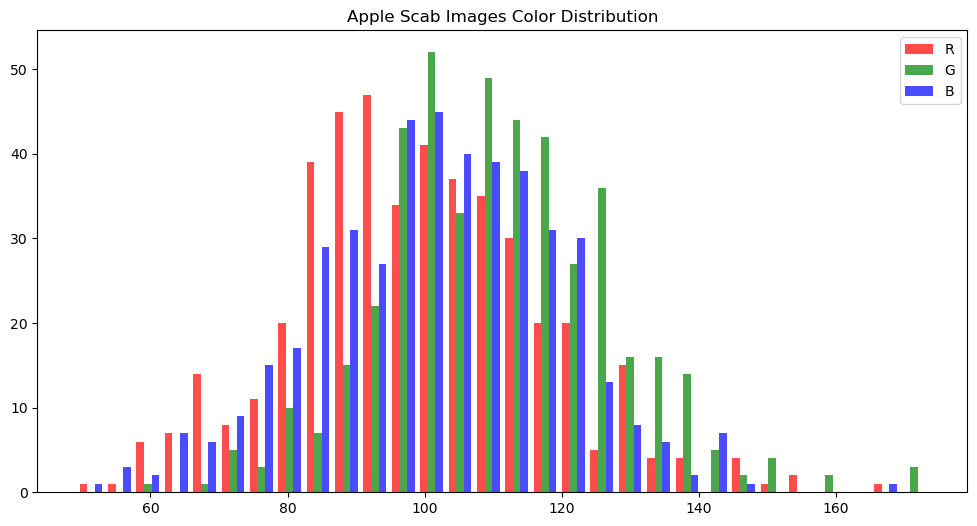

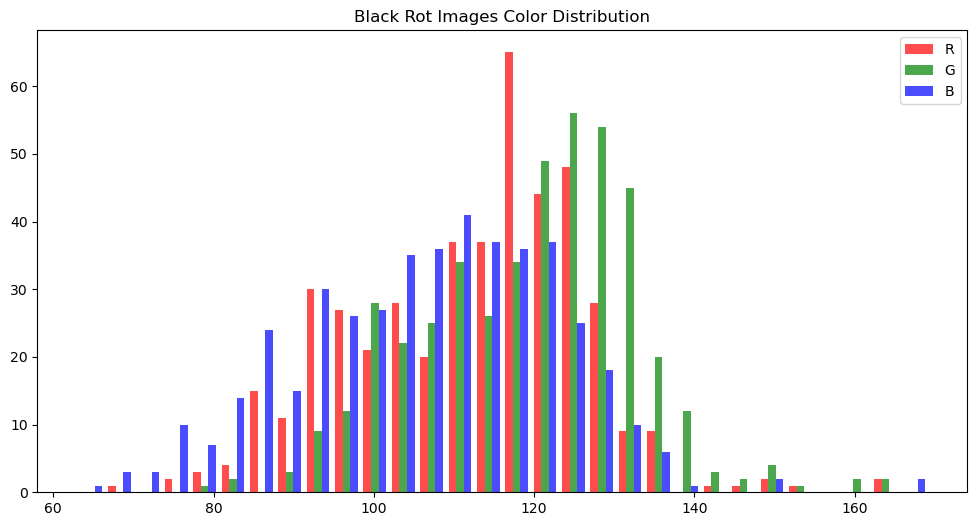

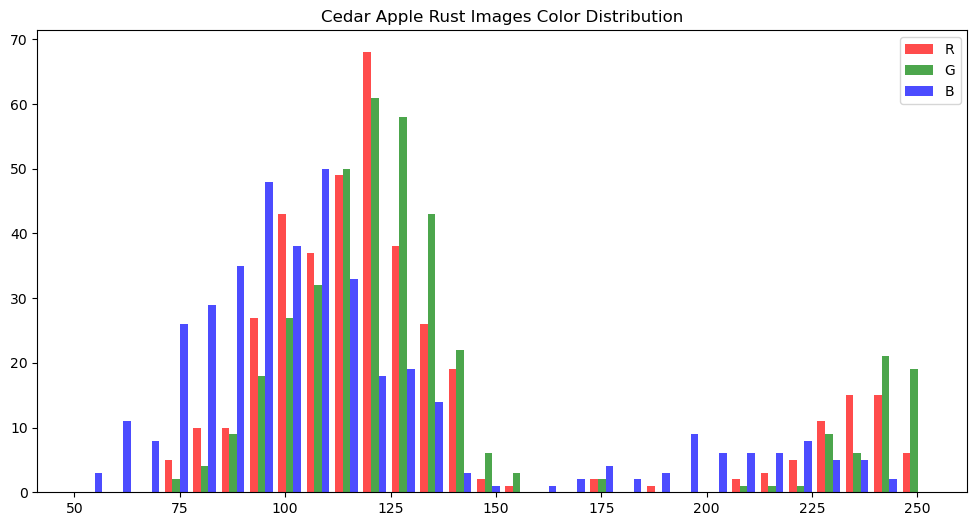

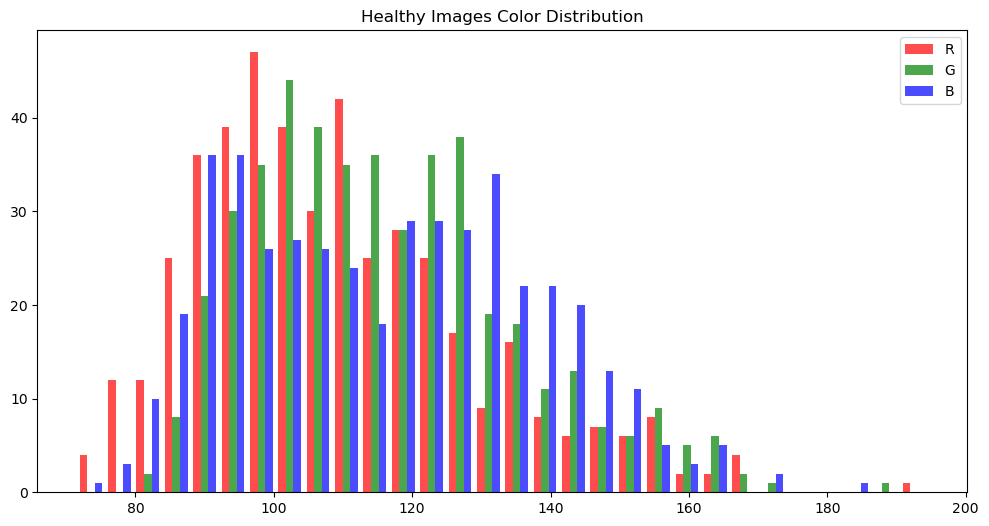

In [20]:
image_path = {category: [os.path.join(path, category, img) for img in os.listdir(os.path.join(path, category))] for category in categories}
categories = ['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']
def get_color_distribution(images):
    color_distributions = []
    for img in images:
        with Image.open(img) as image:
            image = np.array(image)
            color_distributions.append(np.mean(image, axis=(0, 1)))
    return np.array(color_distributions)

for category in categories:
    colors = get_color_distribution(image_path[category])
    
    plt.figure(figsize=(12, 6))
    plt.hist(colors, bins=30, alpha=0.7, label=['R', 'G', 'B'], color=['red', 'green', 'blue'])
    plt.title(f'{category} Images Color Distribution')
    plt.legend()
    plt.show()


1. Apple Scab Images Color Distribution:
Shows a relatively normal distribution centered around 100-120 for all three color channels.
The green channel has the highest peaks, followed by red, then blue.
This suggests that scabbed apples tend to have a greenish-brownish coloration.

2. Black Rot Images Color Distribution (top right):
The distribution is skewed towards lower values (darker colors).
All channels peak around 100-120, but with lower overall values compared to scab images.
This indicates that black rot leads to darker coloration in apples.

3. Cedar Apple Rust Images Color Distribution (bottom left):
Shows a bimodal distribution with peaks around 100-120 and another set of peaks around 200-225.
The red channel has the highest peak in the lower range, while green dominates the higher range.
This suggests that cedar apple rust causes both dark reddish spots and lighter green or yellow areas.

4. Healthy Images Color Distribution (bottom right):
Has the widest distribution among all categories.
Peaks are observed around 100-140 for all channels, with green being slightly more prominent.
There's a secondary peak in the red channel around 200-220.
This indicates that healthy apple leaves have a more varied color palette, likely representing different varieties and stages of ripeness.

In [3]:
root_path = r"Apple\Train"

# Initialize empty lists to store the information
sizes = []
resolutions = []
color_distributions = []

# Iterate over each image file in each subdirectory
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load the image file using OpenCV
            img_path = os.path.join(dirpath, filename)
            img = cv2.imread(img_path)

            # Extract the size of the image
            size = os.path.getsize(img_path)
            sizes.append(size)

            # Extract the resolution of the image
            resolution = img.shape[:2]
            resolutions.append(resolution)

            # Extract the color distribution of the image
            color_distribution = np.bincount(img.flatten(), minlength=256)
            color_distributions.append(color_distribution)

# Convert the lists to numpy arrays for easier manipulation
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

## 4.1. Show Classes

In [4]:
# Show classes

print('Class  : ', data[0][1])
print('Shape  : ', data[0][1].shape)

Class  :  [2. 3. 1. 1. 1. 0. 0. 1. 1. 0. 3. 0. 1. 2. 3. 0. 1. 1. 3. 0. 2. 3. 1. 1.
 3. 1. 2. 0. 1. 1. 3. 3.]
Shape  :  (32,)


## 4.2. Show Class Indices

In [26]:
# Index of category
data.class_indices

{'Apple Scab': 0, 'Black Rot': 1, 'Cedar Apple Rust': 2, 'Healthy': 3}

## 4.3. Show Images from all categories

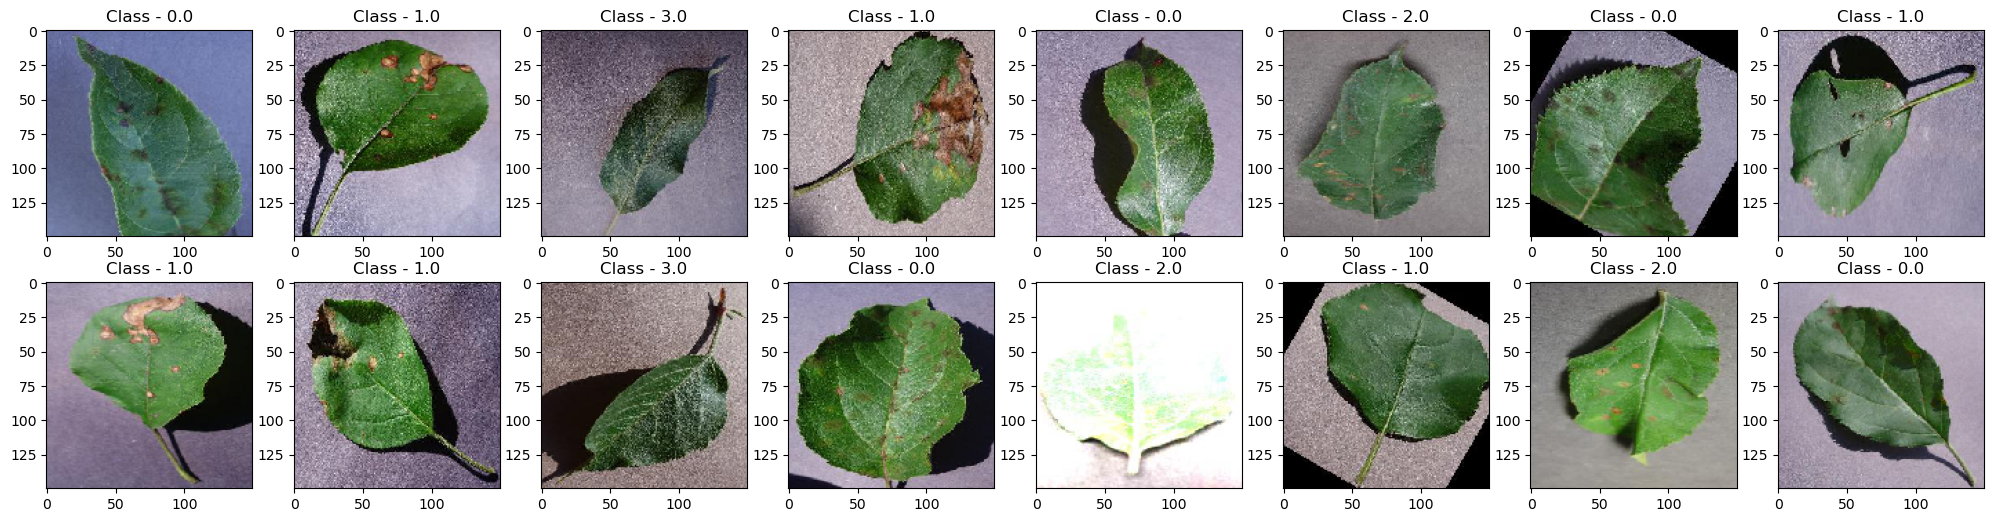

In [27]:
# Show each of image from all categories

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(25,6))
n = 0

for i in range(2):
  for j in range(8):
    img = data[0][0][n].astype('uint8')
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(data[0][1][n]))
    n += 1

## 4.4. Color Analysis

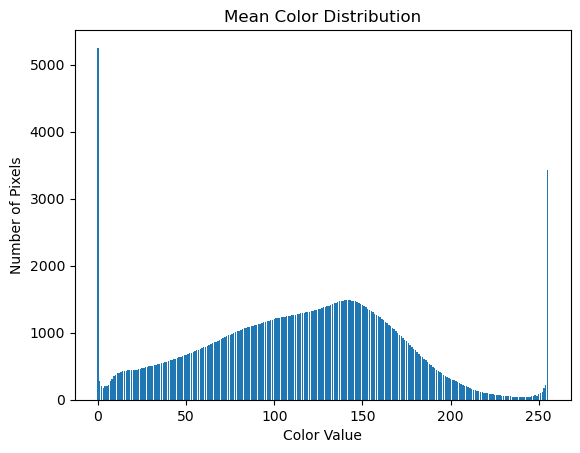

In [5]:
# Calculate the mean color distribution across all images
mean_color_distribution = np.mean(color_distributions, axis=0)

# Plot a bar chart of the mean color distribution
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
plt.show()


 The histogram has a roughly bell-shaped distribution with a peak around the middle range of color values (approximately 125-150). This suggests that the images, on average, have a lot of mid-tone colors

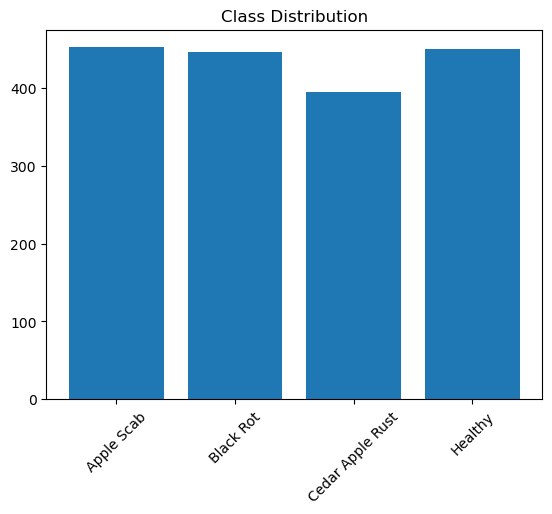

In [6]:
labels, counts = np.unique(data.classes, return_counts=True)
fig, ax = plt.subplots()
ax.bar(labels, counts)
ax.set_xticks(labels)
ax.set_xticklabels(list(data.class_indices.keys()), rotation=45)
ax.set_title('Class Distribution')
plt.show()


From the visualization shown above, there are 4 classes with almost the same data across the classes, so no further data imbalance handling needed to be done.

# 5. Feature Engineering

## 5.1. Data Augmentation

In [8]:
imgen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40, # so the model can recognize the leaf regardless of its orientation
    width_shift_range=0.2, # making the model more robust to different placement of the leaf
    height_shift_range=0.2,    
    shear_range=0.2, # helps the model to recognize the leaf from slightly differt perspectives
    zoom_range=0.2, # help the model recognize the leaf regardless of how closely they are photographed
    horizontal_flip=True, #better generalization for the model as the images could be positioned differently
    vertical_flip=True,
    brightness_range=[0.8, 1.2], # help the model to recognize the leaf under different lightning conditions
    validation_split=0.4,
    rescale=1./255 #rescale the pixel range to 0 and 1
)

In [9]:
train = imgen.flow_from_directory(path,
                                  target_size=(IMG_SIZE, IMG_SIZE),
                                  class_mode='sparse',
                                  subset='training',
                                  shuffle=True,
                                  seed=2
                                  )

val = imgen.flow_from_directory(path,
                                  target_size=(IMG_SIZE, IMG_SIZE),
                                  class_mode='sparse',
                                  subset='validation',
                                  shuffle=True,
                                  seed=2
                                  )

test_path = 'Apple/Test/'

test_set = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test = test_set.flow_from_directory(test_path,
                                    target_size=(IMG_SIZE, IMG_SIZE),
                                    class_mode='sparse',
                                    batch_size=32,
                                    shuffle=False,
                                    seed=2)

Found 1047 images belonging to 4 classes.
Found 696 images belonging to 4 classes.
Found 196 images belonging to 4 classes.


Data augmentation techniques helps the model to generalize better by learning from varied images, reducing overfitting

# 6. ANN Training

## 6.1. Model Definition

In [5]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Create Sequential API model improvement
model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833,380 (18.44 MB)

 Trainable params: 4,833,380 (18.44 MB)

 Non-trainable params: 0 (0.00 B)

## 6.2. Model Training

In [6]:
# Train the model improvement

history_aug = model.fit(train, epochs=20, validation_data=val, batch_size=32)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 745ms/step - accuracy: 0.2782 - loss: 1.4581 - val_accuracy: 0.4075 - val_loss: 1.2605
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 622ms/step - accuracy: 0.4784 - loss: 1.1231 - val_accuracy: 0.6643 - val_loss: 0.7282
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 651ms/step - accuracy: 0.6596 - loss: 0.8031 - val_accuracy: 0.7733 - val_loss: 0.5611
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 647ms/step - accuracy: 0.7461 - loss: 0.6295 - val_accuracy: 0.7489 - val_loss: 0.6216
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 649ms/step - accuracy: 0.7438 - loss: 0.6093 - val_accuracy: 0.6815 - val_loss: 0.8047
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 657ms/step - accuracy: 0.7088 - loss: 0.7359 - val_accuracy: 0.6557 - val_loss: 0.8569
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 905ms/step - accuracy: 0.7308 - loss: 0.7080 - val_accuracy: 0.7762 - val_loss: 0.5865
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 620ms/step - accuracy: 0.7695 - loss: 0.5916 - val_accu

## 6.3. Model Evaluation

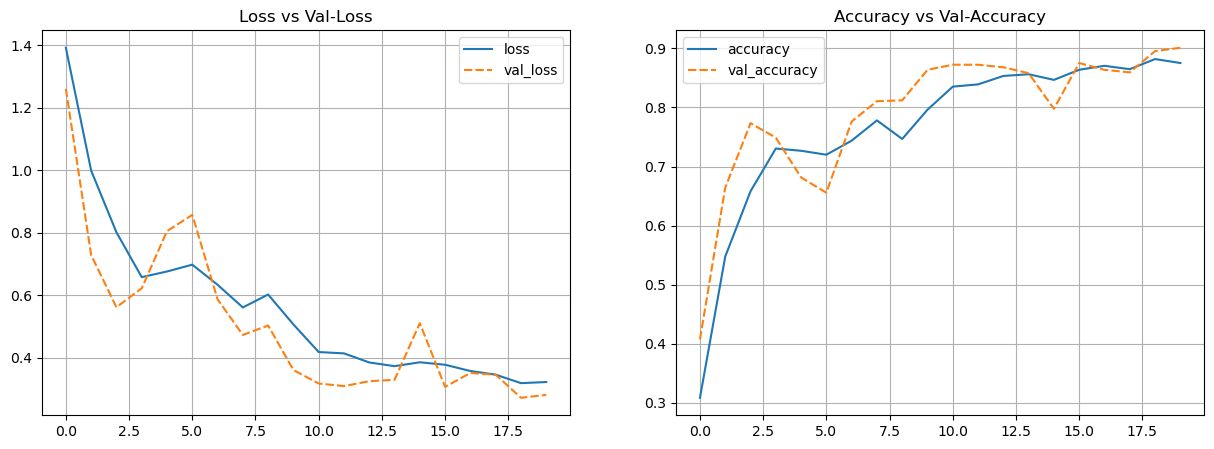

In [7]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [9]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model.predict(test, steps=len(test))

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test.classes, y_pred_class_aug, target_names=np.array(list(train.class_indices.keys()))))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
                  precision    recall  f1-score   support

      Apple Scab       0.97      0.65      0.78        51
       Black Rot       0.78      1.00      0.88        50
Cedar Apple Rust       0.90      0.86      0.88        44
         Healthy       0.79      0.86      0.82        51

        accuracy                           0.84       196
       macro avg       0.86      0.84      0.84       196
    weighted avg       0.86      0.84      0.84       196



# 7. Model Improvement

## 7.1. Model Definition

In [10]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Create Sequential API model
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)))
model_1.add(MaxPooling2D(2, 2))
model_1.add(Conv2D(64, (3,3), activation='relu'))
model_1.add(MaxPooling2D(2, 2))
model_1.add(Conv2D(128, (3,3),activation='relu'))
model_1.add(MaxPooling2D(2, 2))
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(4, activation='softmax'))

# Compile
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## 7.2. Model Training

In [11]:
# Train the model

history_aug_1 = model_1.fit(train, epochs=20, validation_data=val, batch_size=32)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - accuracy: 0.2986 - loss: 2.0236 - val_accuracy: 0.6341 - val_loss: 0.8594
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step - accuracy: 0.6564 - loss: 0.8621 - val_accuracy: 0.5768 - val_loss: 0.9488
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - accuracy: 0.6594 - loss: 0.7822 - val_accuracy: 0.6585 - val_loss: 0.7798
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - accuracy: 0.7189 - loss: 0.7111 - val_accuracy: 0.8207 - val_loss: 0.4559
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step - accuracy: 0.7752 - loss: 0.5429 - val_accuracy: 0.7762 - val_loss: 0.5612
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - accuracy: 0.7594 - loss: 0.5822 - val_accuracy: 0.7877 - val_loss: 0.5406
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 449ms/step - accuracy: 0.8028 - loss: 0.4885 - val_accuracy: 0.7647 - val_loss: 0.5442
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.7794 - loss: 0.5209 - val_accu

## 7.3. Model Evaluation

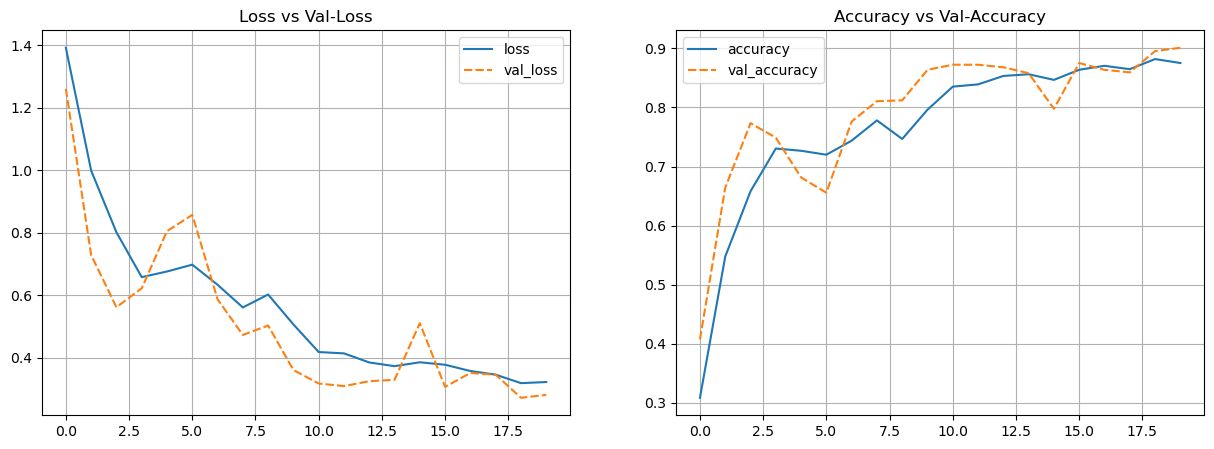

In [12]:
# Plot training results

history_aug_df_1 = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df_1[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [13]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug_1 = model_1.predict(test, steps=len(test))

## Get class with maximum probability
y_pred_class_aug_1 = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test.classes, y_pred_class_aug_1, target_names=np.array(list(train.class_indices.keys()))))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
                  precision    recall  f1-score   support

      Apple Scab       0.97      0.65      0.78        51
       Black Rot       0.78      1.00      0.88        50
Cedar Apple Rust       0.90      0.86      0.88        44
         Healthy       0.79      0.86      0.82        51

        accuracy                           0.84       196
       macro avg       0.86      0.84      0.84       196
    weighted avg       0.86      0.84      0.84       196



Model improvement, walaupun menghasilkan nilai accuracy yang sama dibandingkan dengan model sebelumnya, namun model improvement ini mampu melakukan training dalam waktu yang lebih singkat

# 8. Model Saving

In [14]:
# Model summary

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,107,150 (217.85 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,071,434 (145.23 MB)

In [15]:
# Freeze model
model_1.trainable = False
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,107,150 (217.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,035,716 (72.62 MB)

 Optimizer params: 38,071,434 (145.23 MB)

In [16]:
# Save model as keras file
model_1.save('sequential_model.keras')

# 9. Model Inference

Model inference can be accessed here [P2G7_wawan_inference.ipynb](P2G7_wawan_inference.ipynb)

# 10. Conclusion

1. Model's Strength - the model can correctly tell apart which plant get the disease based on the image of the leaf, regardless the shape of the leaf, as long as it's a leaf of an apple tree
2. Model's Weakness - the model might struggle to identify when it's given an image of a leaf from other than apple tree
3. By detecting harmful disease on apple trees using the help of this model, the company can reduce significant number of worker with special set of skills to detect disease on the tree
4. This model certainly can be better if also trained using leaves' images from various kind of plants
5. The dataset is well-distributed among the four categories, providing a solid foundation for training a model